# Introduction
Name | Abid Ilmun Fisabil<br>
Batch | FTDS - 006<br>
Phase | 1

## **Problem**  
    
    Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
    Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

    Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.
    
    People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

## **Data Description**

### **Data Attributes:**
1. age - Age
2. anaemia - Decrease of red blood cells or hemoglobin (boolean) 
3. creatinine_phosphokinase - Level of the CPK enzyme in the blood (mcg/L)
4. diabetes - If the patient has diabetes (boolean)
5. ejection_fraction - Percentage of blood leaving the heart at each contraction (percentage)
6. high_blood_pressure - If the patient has hypertension (boolean)
7. platelets - Platelets in the blood (kiloplatelets/mL)
8. serum_creatinine -  Level of serum creatinine in the blood (mg/dL)
10. serum_sodium - Level of serum sodium in the blood (mEq/L)
11. sex - Woman or man (binary)

### **Source**
Davide Chicco, Giuseppe Jurman: Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Medical Informatics and Decision Making 20, 16 (2020)

https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

# Importing Packages

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer as mct
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import classification_report as cr
from sklearn import metrics
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')



# Data Loading

In [172]:
#reading dataset
df = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
#displaying first 5 rows
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Data Attributes Inspection 

In [173]:
#inspecting data information
df.info()
#inspecting null values
print('\n',df.isnull().sum(),'\n')
#inspecting data shape
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB

 age             

(299, 13)

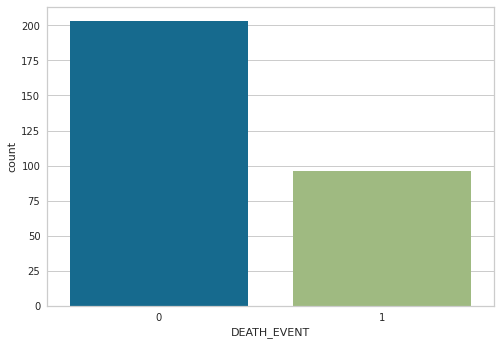

In [174]:
#target feature imbalancy check
sns.countplot(data = df, x = 'DEATH_EVENT');

In [175]:
#checking for categorical features
for i in df.columns:
    print('-'*80)
    print(f'{i.upper()}\n')
    print(df[i].unique(),'\n\n')

--------------------------------------------------------------------------------
AGE

[75.    55.    65.    50.    90.    60.    80.    62.    45.    49.
 82.    87.    70.    48.    68.    53.    95.    58.    94.    85.
 69.    72.    51.    57.    42.    41.    67.    79.    59.    44.
 63.    86.    66.    43.    46.    61.    81.    52.    64.    40.
 60.667 73.    77.    78.    54.    47.    56.   ] 


--------------------------------------------------------------------------------
ANAEMIA

[0 1] 


--------------------------------------------------------------------------------
CREATININE_PHOSPHOKINASE

[ 582 7861  146  111  160   47  246  315  157  123   81  231  981  168
   80  379  149  125   52  128  220   63  148  112  122   60   70   23
  249  159   94  855 2656  235  124  571  127  588 1380  553  129  577
   91 3964   69  260  371   75  607  789  364 7702  318  109   68  250
  110  161  113 5882  224   92  102  203  336   76   55  280   78   84
  115   66  897  154  144  

In [176]:
#seperating categorical and numerical column names
cat_cols = ['anaemia','diabetes','high_blood_pressure','sex','DEATH_EVENT','smoking']
num_cols = [i for i in df.columns if i not in cat_cols] 

In [177]:
#convering float age feature into integer
df.age = [int(np.floor(i)) for i in df.age]

In [178]:
#creating dictionaries for value transformers
transformers = {
    'yjs':PowerTransformer('yeo-johnson'),
    'bcx':PowerTransformer('box-cox'),
    'cbrt':FunctionTransformer(np.cbrt),
    'log1p':FunctionTransformer(np.log1p)
}

In [179]:
#comparing original and transformed data using all transformer element in transformers dictionary
print('original\n')
print(df[num_cols].skew(),'\n\n')
for i in list(transformers.keys()):
    print(f'{i}\n')
    try:
        print(transformers[i].fit_transform(df[num_cols]+1).skew(),'\n\n')
    except:
        print(pd.DataFrame(transformers[i].fit_transform(df[num_cols]+1),columns = num_cols).skew(),'\n\n')

original

age                         0.424172
creatinine_phosphokinase    4.463110
ejection_fraction           0.555383
platelets                   1.462321
serum_creatinine            4.455996
serum_sodium               -1.048136
time                        0.127803
dtype: float64 


yjs

age                        -0.000127
creatinine_phosphokinase    0.045786
ejection_fraction          -0.006111
platelets                   0.155358
serum_creatinine            0.216907
serum_sodium                0.082252
time                       -0.212463
dtype: float64 


bcx

age                        -0.000657
creatinine_phosphokinase    0.044225
ejection_fraction          -0.006637
platelets                   0.155360
serum_creatinine            0.150381
serum_sodium                0.082305
time                       -0.217922
dtype: float64 


cbrt

age                         0.132342
creatinine_phosphokinase    1.446308
ejection_fraction           0.032803
platelets                  -0.26

**Initial Findings**

1. the data is shaped 299 rows and 13 columns and consists of all numerical values with numerical and categorical features present.
2. no null values or duplicates
3. imbalanced where positive target counts for only half of negative target
4. value 66.667 as an age
5. with thresholds of absolute 1, data consits of 5 skewed features. using cuber root and log1p skewed features equals 4. using YeoJohnson and BoxCox skewed features equals 0

## Visualization

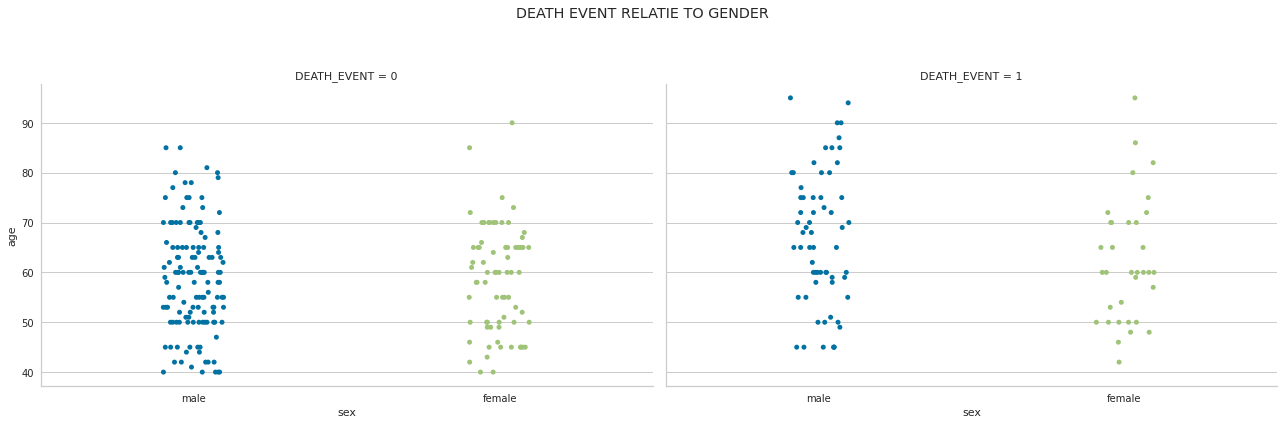

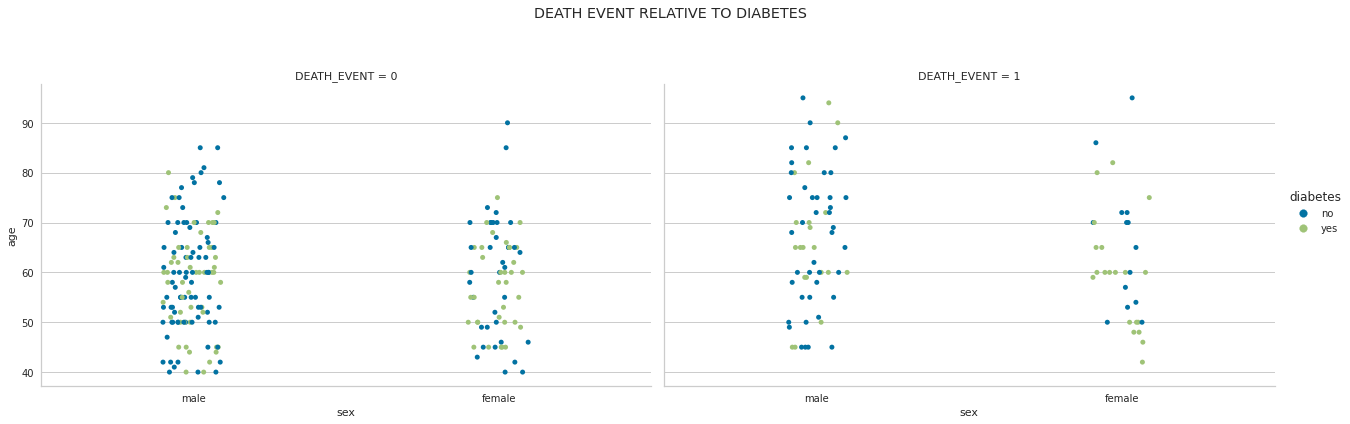

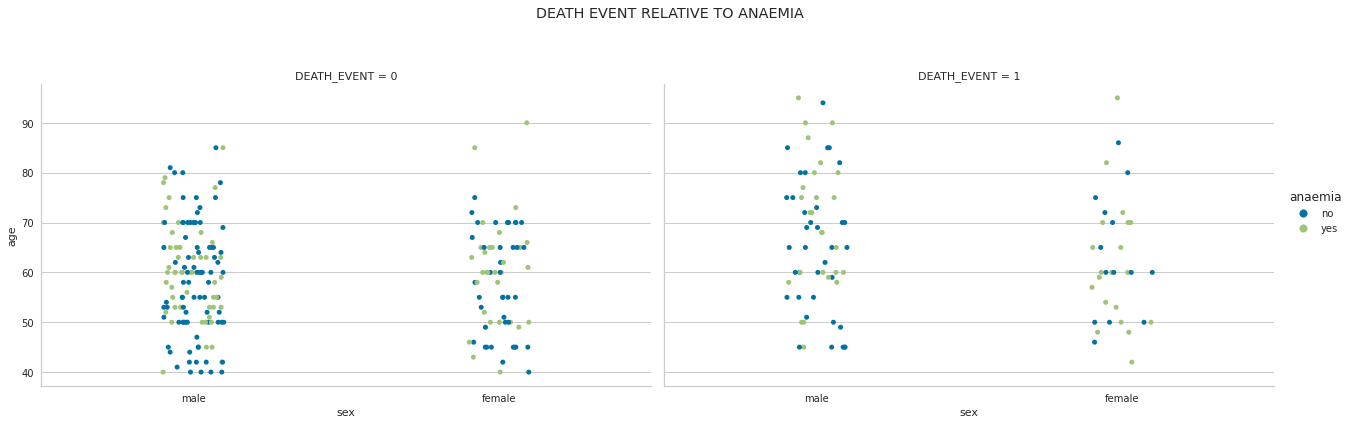

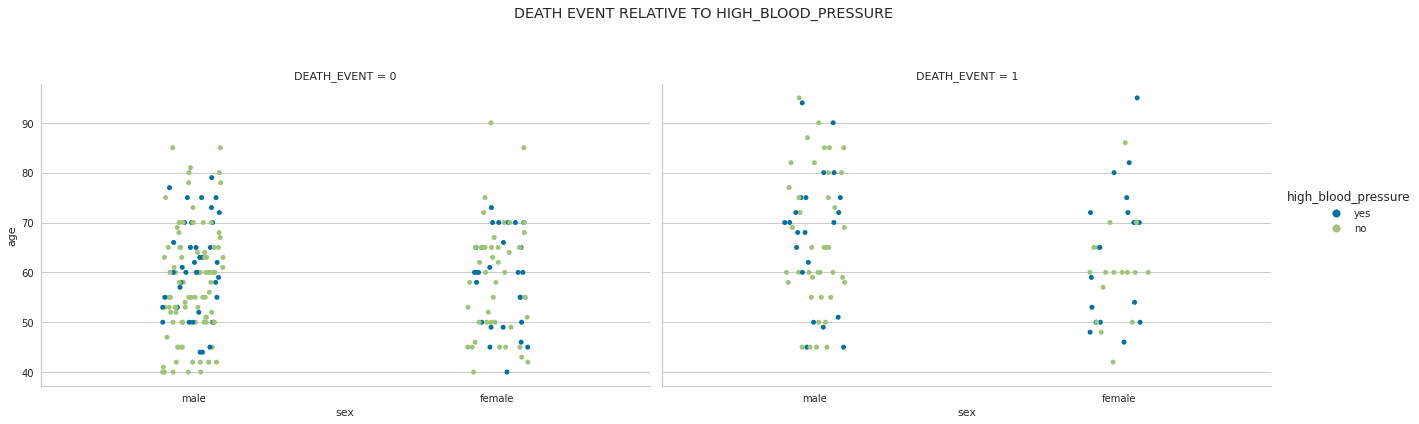

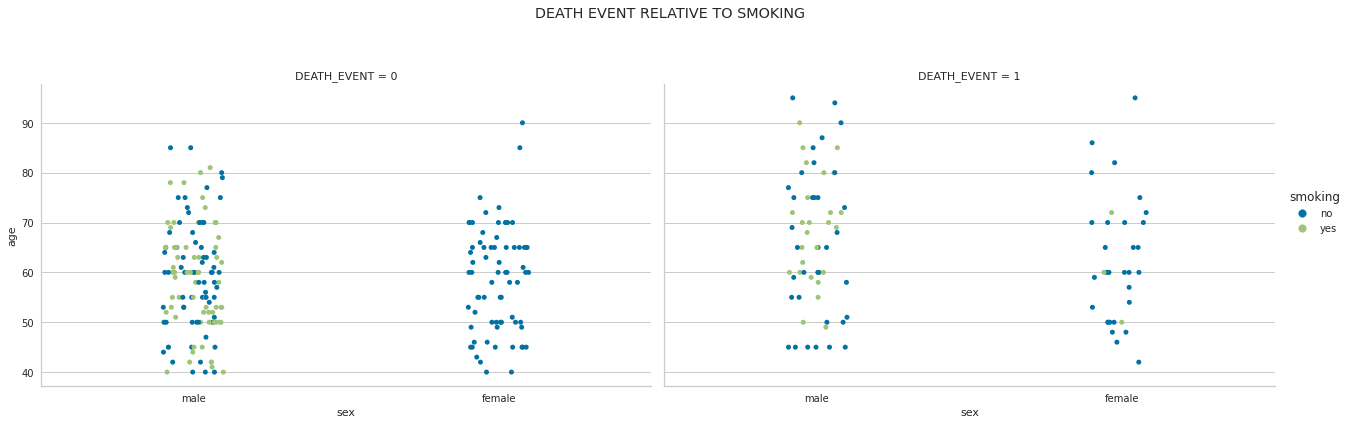

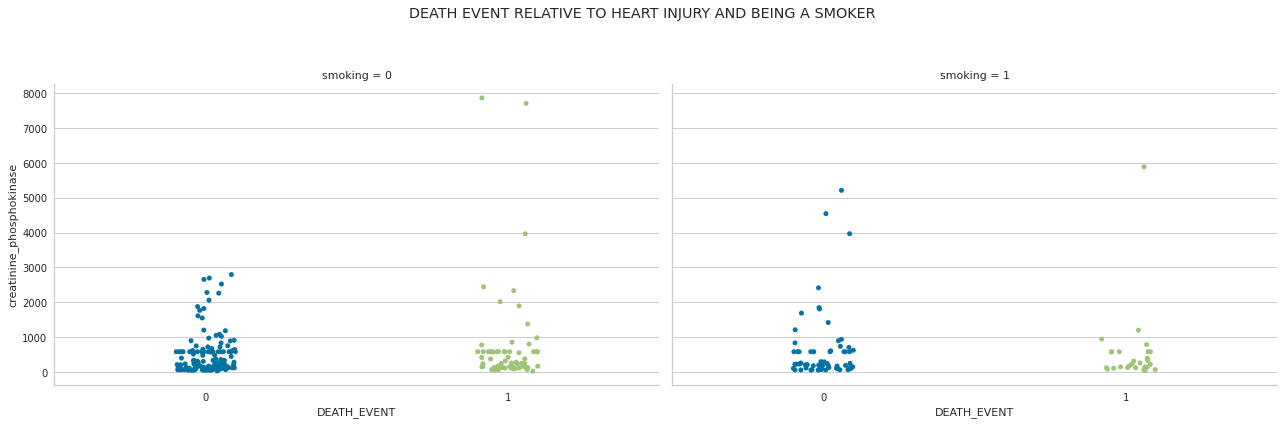

In [182]:
#prepering dataset for visualization
dff = df.copy()
dff.anaemia = ['yes' if i == 1 else 'no' for i in dff.anaemia]
dff.diabetes = ['yes' if i == 1 else 'no' for i in dff.diabetes]
dff.smoking = ['yes' if i == 1 else 'no' for i in dff.smoking]
dff.high_blood_pressure = ['yes' if i == 1 else 'no' for i in dff.high_blood_pressure]
dff.sex = ['male' if i == 1 else 'female' for i in dff.sex]
#selecting columns for categorical visualization 
cols = ['diabetes', 'anaemia', 'high_blood_pressure', 'smoking']
#plotting categorical features
#catplot row 1
fig = sns.catplot(data = dff, col = 'DEATH_EVENT',y = 'age', x= 'sex', height=6, aspect=1.5)
fig.fig.subplots_adjust(top=.8)
fig.fig.suptitle('death event relatie to gender'.upper())
#catplot row 2-4
for col in cols:
    fig = sns.catplot(data = dff, col = 'DEATH_EVENT',y = 'age', x= 'sex', hue = col, height=6, aspect=1.5)
    fig.fig.subplots_adjust(top=.8)
    fig.fig.suptitle(f'death event relative to {col}'.upper())
#catplot row 5
fig = sns.catplot(data = df, y = 'creatinine_phosphokinase',x = 'DEATH_EVENT',col = 'smoking', height=6, aspect=1.5)
fig.fig.subplots_adjust(top=.8)
fig.fig.suptitle('death event relative to heart injury and being a smoker'.upper());

**Interpretation**

1. more male are experiencing heart failure. and more male also died from it
2. peaple are experiencing heart failure afed 40 to 90. the older a person the lesser chance they will experience heart failure
3. more people surviving from heart failure 
4. relatively most of females have diabetes. and most males don't have diabetes
5. most of the females that died from heart failure, they have diebetes
6. most of males that died from heart failure dont have diabetes
7. most of deceased male don't have high blood pressure and vice versa for the female
8. most smoking female are safe from dying from hear failure and most of female are smoking. that means only smoking female suffering from heart failure but luckily they get the chance to see tomorrow
9. suprisingly severly injured heart smoker mostly safe from dying from a heart failure. but severly injured heart non smoker mostly died from heart failure

# Model Building

In [183]:
#reseperating columns for modelling
cat_cols = ['anaemia','diabetes','high_blood_pressure','sex','smoking']
num_cols = [i for i in df.columns[:-1] if i not in cat_cols] 
#creating model dictionary
models = {
    'RandomForestClassifier' :RandomForestClassifier(random_state = 42,n_jobs = -1),
    'GradientBoostingClassifier' :GradientBoostingClassifier(random_state = 42),
    'HistGradientBoostingClassifier' :HistGradientBoostingClassifier(random_state =42)
}
#creating transformer dictionary
numTransformers = {
    'YeoJohnson' :PowerTransformer(method = 'yeo-johnson'),
    'boxcox' :PowerTransformer(method = 'box-cox'),
    'cbrt' : FunctionTransformer(func = np.cbrt),
    'log1p' : FunctionTransformer(func = np.log1p)
}
#creating scaler dictionary
scalers = {
    'MinMaxScaler' :MinMaxScaler(),
    'StandardScaler' :StandardScaler(),
    'RobustScaler' :RobustScaler()
}

## Initial Models

In [184]:
model_keys = list(models.keys())
metrics_ = {}
for mod in model_keys:
    
    x = df[df.columns[:-1]]
    y = df[df.columns[-1]]

    xtrain,xtest,ytrain,ytest = tts(x,y,test_size = .8, random_state = 42, stratify = y)

    model = models[mod]
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    metrics_[mod] = [metrics.accuracy_score(ytest,ypred),
                         metrics.precision_score(ytest,ypred),
                         metrics.recall_score(ytest,ypred),
                         metrics.f1_score(ytest,ypred)]
base_models_result = pd.DataFrame(metrics_,index = ['acc','prec','rec','f1'])


## Model With Transformed Data

In [185]:
model_keys = list(models.keys())
metrics_ = {}
for mod in model_keys:
    
    x = df[df.columns[:-1]]
    y = df[df.columns[-1]]

    xtrain,xtest,ytrain,ytest = tts(x,y,test_size = .8, random_state = 42, stratify = y)
    
    ct = mct(
        (numTransformers['YeoJohnson'],num_cols)
    )
    pipe = Pipeline([
        ('ct',ct),
        ('clf',models[mod])
    ])
    
    pipe.fit(xtrain,ytrain)
    ypred = pipe.predict(xtest)
    metrics_[mod] = [metrics.accuracy_score(ytest,ypred),
                         metrics.precision_score(ytest,ypred),
                         metrics.recall_score(ytest,ypred),
                         metrics.f1_score(ytest,ypred)]
norm_models_result = pd.DataFrame(metrics_,index = ['acc','prec','rec','f1'])


## Model With Scaled Data

In [186]:
model_keys = list(models.keys())
metrics_ = {}
for mod in model_keys:
    
    x = df[df.columns[:-1]]
    y = df[df.columns[-1]]

    xtrain,xtest,ytrain,ytest = tts(x,y,test_size = .8, random_state = 42, stratify = y)
    
    ct = mct(
        (scalers['MinMaxScaler'],xtrain.columns)
    )
    pipe = Pipeline([
        ('ct',ct),
        ('clf',models[mod])
    ])
    
    pipe.fit(xtrain,ytrain)
    ypred = pipe.predict(xtest)
    metrics_[mod] = [metrics.accuracy_score(ytest,ypred),
                         metrics.precision_score(ytest,ypred),
                         metrics.recall_score(ytest,ypred),
                         metrics.f1_score(ytest,ypred)]
scaled_models_result = pd.DataFrame(metrics_,index = ['acc','prec','rec','f1'])


## Model With Transformed And Scaled Data

In [187]:
model_keys = list(models.keys())
metrics_ = {}
for mod in model_keys:
    
    x = df[df.columns[:-1]]
    y = df[df.columns[-1]]

    xtrain,xtest,ytrain,ytest = tts(x,y,test_size = .8, random_state = 42, stratify = y)
    
    ct = mct(
        (numTransformers['YeoJohnson'],num_cols),
        (scalers['MinMaxScaler'],xtrain.columns)
    )
    pipe = Pipeline([
        ('ct',ct),
        ('clf',models[mod])
    ])
    
    pipe.fit(xtrain,ytrain)
    ypred = pipe.predict(xtest)
    metrics_[mod] = [metrics.accuracy_score(ytest,ypred),
                         metrics.precision_score(ytest,ypred),
                         metrics.recall_score(ytest,ypred),
                         metrics.f1_score(ytest,ypred)]
scaled_normed_models_result = pd.DataFrame(metrics_,index = ['acc','prec','rec','f1'])


# Model Evalutaion

In [188]:
print('original data\n'.upper())
display(base_models_result)
print('\nonly scaled\n'.upper())
display(scaled_models_result)
print('\nonly normalization\n'.upper())
display(norm_models_result)
print('\nscaled and normalized\n'.upper())
display(scaled_normed_models_result)

ORIGINAL DATA



,RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
acc,0.808333,0.820833,0.783333
prec,0.746032,0.765625,0.735849
rec,0.610390,0.636364,0.506494
f1,0.671429,0.695035,0.600000



ONLY SCALED



,RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
acc,0.808333,0.820833,0.783333
prec,0.746032,0.765625,0.735849
rec,0.610390,0.636364,0.506494
f1,0.671429,0.695035,0.600000



ONLY NORMALIZATION



,RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
acc,0.816667,0.820833,0.775000
prec,0.753846,0.765625,0.709091
rec,0.636364,0.636364,0.506494
f1,0.690141,0.695035,0.590909



SCALED AND NORMALIZED



,RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
acc,0.825000,0.820833,0.783333
prec,0.777778,0.765625,0.735849
rec,0.636364,0.636364,0.506494
f1,0.700000,0.695035,0.600000


#### **Model Interpretation**
**RandomForestClassifier**<br>
scaling cannot improve the model. but when transformation is applied, performance of the model increased end even more when scaling and transformation combined<br><br>
**GradientBoostingClassifier**<br>
any kind of methods in place could not improve this particular model<br><br>
**HistGradientBoostingClassifier**<br>
scaliing dont affect anything to the model performance and transformation even decreased them. but when scaling and transformation combined, the model improved by a bit

#### **Model Selection**
the data will be scaled then transformed as it gave better performance. as for the model **RandomForestClassifier** will be chosen as it has best performance than the other two

# Model Finalization

In [189]:
x = df[df.columns[:-1]]
y = df[df.columns[-1]]

xtrain,xtest,ytrain,ytest = tts(x,y,test_size = .8, random_state = 42, stratify = y)

ct = mct(
    (numTransformers['YeoJohnson'],num_cols),
    (scalers['MinMaxScaler'],xtrain.columns)
)
pipe = Pipeline([
    ('ct',ct),
    ('clf',models['RandomForestClassifier'])
])

pipe.fit(xtrain,ytrain)
ypred = pipe.predict(xtest)
print(cr(ytest,ypred))


              precision    recall  f1-score   support

           0       0.84      0.91      0.88       163
           1       0.78      0.64      0.70        77

    accuracy                           0.82       240
   macro avg       0.81      0.78      0.79       240
weighted avg       0.82      0.82      0.82       240



**Interpretation**

the model is doing pretty decent. as we can see positive targets in test set hold 77 observations. note that the whole positive targets are only accounting less than 100 observations. that means our model is able to get 70% f1 score using imbalanced data when it trained with only 20 to 30% positive targets. even though the model is only able to predict 64% from all 77 positive targets,from all its postive prediction, it is able to get 78% of them correct.

# Model Inference

In [190]:
obs = df[df.columns[:-1]].sample(1,random_state = 1)
display(obs)
pred = pipe.predict(obs)
if pred == 1:
    print('potentially die from a heart failure')
else:
    print('probably safe from dying because of a heart failure')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
173,50,1,115,0,20,0,189000.0,0.8,139,1,0,146


potentially die from a heart failure
